### Packages and Settings

In [1]:
import time
import datetime
import numpy as np
import pandas as pd
from itertools import product
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn import datasets, linear_model
from sklearn.metrics import mean_squared_error
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor

## EDA & Feature Engineering

In [2]:
train = pd.read_csv('sales_train.csv')
items = pd.read_csv('items.csv')
items = items.drop('item_name', axis=1)
test  = pd.read_csv('test.csv').set_index('ID')
test['date_block_num'] = 34

In [3]:
# Compress data size, get the ranges of each feature to select the most appropriate data size
print ('train:')
for f in train.columns.values:
    print ('%s: %s ~ %s' %(f, train[f].min(), train[f].max()))
print ('items:')
for f in items.columns.values:
    print ('%s: %s ~ %s' %(f, items[f].min(), items[f].max()))
print ('test:')
for f in test.columns.values:
    print ('%s: %s ~ %s' %(f, test[f].min(), test[f].max()))

train:
date: 01.01.2013 ~ 31.12.2014
date_block_num: 0 ~ 33
shop_id: 0 ~ 59
item_id: 0 ~ 22169
item_price: -1.0 ~ 307980.0
item_cnt_day: -22.0 ~ 2169.0
items:
item_id: 0 ~ 22169
item_category_id: 0 ~ 83
test:
shop_id: 2 ~ 59
item_id: 30 ~ 22167
date_block_num: 34 ~ 34


In [4]:
def compress_col(df,columns,keyword,search_type,datatype):
    if search_type=='in':
        valid_features = [x for x in columns if keyword in x]
    elif search_type=='start':
        valid_features = [x for x in columns if x.startswith(keyword)]
    if len(valid_features):
        for f in valid_features:
            df[f] = df[f].round().astype(datatype)
    return df

# Original-features
def data_compression(df):
    features = df.columns.values
    if 'date_block_num' in features:
        df['date_block_num'] = df['date_block_num'].astype(np.int8)
    if 'shop_id' in features:
        df['shop_id'] = df['shop_id'].astype(np.int8)
    if 'item_category_id' in features:
        df['item_category_id'] = df['item_category_id'].astype(np.int8)
    if 'item_id' in features:
        df['item_id'] = df['item_id'].astype(np.int16)
    if 'item_price' in features:
        df['item_price'] = df['item_price'].astype(np.float32)
    if 'item_id_avg_item_price' in features:
        df['item_id_avg_item_price'] = df['item_id_avg_item_price'].astype(np.float32)
        
    # Mean encoded features & lag features
    df = compress_col(df,features,'item_id_sum_item_cnt_day','in',np.int16)
    df = compress_col(df,features,'item_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_col(df,features,'shop_id_avg_item_price','in',np.float16)
    df = compress_col(df,features,'shop_id_sum_item_cnt_day','in',np.int16)
    df = compress_col(df,features,'shop_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_col(df,features,'item_category_id_avg_item_price','in',np.float16)
    df = compress_col(df,features,'item_category_id_sum_item_cnt_day','in',np.int32)
    df = compress_col(df,features,'item_category_id_avg_item_cnt_day','in',np.float16)
    
    df = compress_col(df,features,'item_cnt_day','start',np.int16)
    return df

In [5]:
# Compress features
train = data_compression(train)
items = data_compression(items)
test = data_compression(test)
# Include Category_id
train = pd.merge(train,items,on='item_id',how='left')
test = pd.merge(test,items, on='item_id', how='left')

In [6]:
# Merge duplicated shops
train.loc[train.shop_id == 0, 'shop_id'] = 57
test.loc[test.shop_id == 0, 'shop_id'] = 57
train.loc[train.shop_id == 1, 'shop_id'] = 58
test.loc[test.shop_id == 1, 'shop_id'] = 58
train.loc[train.shop_id == 10, 'shop_id'] = 11
test.loc[test.shop_id == 10, 'shop_id'] = 11

In [7]:
#Feature Distributions
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2935849 entries, 0 to 2935848
Data columns (total 7 columns):
 #   Column            Dtype  
---  ------            -----  
 0   date              object 
 1   date_block_num    int8   
 2   shop_id           int8   
 3   item_id           int16  
 4   item_price        float32
 5   item_cnt_day      int16  
 6   item_category_id  int8   
dtypes: float32(1), int16(2), int8(3), object(1)
memory usage: 75.6+ MB


In [8]:
# Outliers removal, getting rid of the outliers & negative values
train = train[(train['item_price']<100000) & (train['item_price']>=0)]
train = train[(train['item_cnt_day']<1000) & (train['item_cnt_day']>=0)]

# Distribution after outliers removal
# plot_features = ['item_price','item_cnt_day']
# for f in plot_features:
#     box_plot(train,f)

In [9]:
# Created a dataframe of date_block_num, Store and Item combinations
# Created a grid with columns
index_cols = ['shop_id','item_id','date_block_num']

# For every month we create a grid for all shops & items pair
grid = []
for block_num in train['date_block_num'].unique():
    cur_shops = train.loc[train['date_block_num']==block_num,'shop_id'].unique()
    cur_items = train.loc[train['date_block_num']==block_num,'item_id'].unique()
    grid.append(np.array(list(product(*[cur_shops,cur_items,[block_num]])),dtype='int32'))
grid = pd.DataFrame(np.vstack(grid),columns=index_cols,dtype=np.int32)
grid = data_compression(grid)
grid.head()

,shop_id,item_id,date_block_num
0,59,22154,0
1,59,2552,0
2,59,2554,0
3,59,2555,0
4,59,2564,0


In [10]:
grid.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10884508 entries, 0 to 10884507
Data columns (total 3 columns):
 #   Column          Dtype
---  ------          -----
 0   shop_id         int8 
 1   item_id         int16
 2   date_block_num  int8 
dtypes: int16(1), int8(2)
memory usage: 41.5 MB


In [11]:
#Created Mean Encodings
#Group items per month, per shop, per item, sum the sales of the item, mean the price
#There is a big difference between np.mean and pandas mean
train_m = train.groupby(['date_block_num','shop_id','item_id']).agg({'item_cnt_day':'sum','item_price':np.mean}).reset_index()
train_m = pd.merge(grid,train_m,on=['date_block_num','shop_id','item_id'],how='left').fillna(0)
train_m = pd.merge(train_m,items,on='item_id',how='left')
train_m = data_compression(train_m)

In [12]:
# Making the mean encoded features
for type_id in ['item_id', 'shop_id', 'item_category_id']:
    for column_id, aggregator, aggtype in [('item_price',np.mean,'avg'),('item_cnt_day',np.sum,'sum'),('item_cnt_day',np.mean,'avg')]:
        mean_df = train.groupby([type_id,'date_block_num']).aggregate(aggregator).reset_index()[[column_id,type_id,'date_block_num']]
        mean_df.columns = [type_id+'_'+aggtype+'_'+column_id,type_id,'date_block_num']
        train_m = pd.merge(train_m, mean_df, on=['date_block_num',type_id], how='left')
        del mean_df

In [13]:
#Fill NaNs
for f in train_m.columns:
    if 'item_cnt' in f:
        train_m[f] = train_m[f].fillna(0)
    elif 'item_price' in f:
        train_m[f] = train_m[f].fillna(train_m[f].median())

# Compress data
train_m = data_compression(train_m)
train_m.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10884508 entries, 0 to 10884507
Columns: 15 entries, shop_id to item_category_id_avg_item_cnt_day
dtypes: float16(5), float32(2), int16(4), int32(1), int8(3)
memory usage: 425.6 MB


In [14]:
#Created Lag Features
#Check the positions of the base lag features
train_m.columns.values[6:]

array(['item_id_avg_item_price', 'item_id_sum_item_cnt_day',
       'item_id_avg_item_cnt_day', 'shop_id_avg_item_price',
       'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day',
       'item_category_id_avg_item_price',
       'item_category_id_sum_item_cnt_day',
       'item_category_id_avg_item_cnt_day'], dtype=object)

In [15]:
# Get all the monthly features, which means the Mean Encoded fatures are all monthly based
lag_features = list(train_m.columns[6:])+['item_cnt_day']
# The selected months from current month
lags = [1,2,3,6]

In [16]:
for lag in lags:
    train_new_df = train_m.copy()
    # Get the current month
    train_new_df['date_block_num'] += lag
    train_new_df = train_new_df[['date_block_num','shop_id','item_id']+lag_features]
    # Name the columns as lag features of the month
    train_new_df.columns = ['date_block_num','shop_id','item_id'] + [x+'_lag_'+str(lag) for x in lag_features]
    train_m = pd.merge(train_m,train_new_df,on=['date_block_num','shop_id','item_id'],how='left')
    del train_new_df
    print ('lag %s processed' %lag)

lag 1 processed
lag 2 processed
lag 3 processed
lag 6 processed


In [17]:
# Fill NaNs
for f in train_m.columns:
    if 'item_cnt' in f:
        train_m[f] = train_m[f].fillna(0)
    elif 'item_price' in f:
        train_m[f] = train_m[f].fillna(train_m[f].median())

train_m = data_compression(train_m)
train_m.info(verbose=False)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10884508 entries, 0 to 10884507
Columns: 55 entries, shop_id to item_cnt_day_lag_6
dtypes: float16(25), float32(6), int16(16), int32(5), int8(3)
memory usage: 1.4 GB


In [18]:
# Set the maximum clip value
# Prepare test set
max_clip = 30
train_m['item_cnt_day'] = train_m['item_cnt_day'].clip(0,max_clip).astype(np.float16)

In [19]:
# Add lag variables
for lag in lags:
    train_new_df = train_m.copy()
    # Get the current month
    train_new_df['date_block_num'] += lag
    train_new_df = train_new_df[['date_block_num','shop_id','item_id']+lag_features]
    # Name the columns as lag features of the month
    train_new_df.columns = ['date_block_num','shop_id','item_id'] + [x+'_lag_'+str(lag) for x in lag_features]
    test = pd.merge(test,train_new_df,on=['date_block_num','shop_id','item_id'],how='left')
    del train_new_df
    print ('lag %s processed' %lag)

lag 1 processed
lag 2 processed
lag 3 processed
lag 6 processed


In [20]:
# Fill NaNs
for f in test.columns:
    if 'item_cnt' in f:
        test[f] = test[f].fillna(0)
    elif 'item_price' in f:
        test[f] = test[f].fillna(test[f].median())

test = data_compression(test)

In [21]:
#Drop all columns which are not lag features
cols_to_drop = lag_features[:-1] + ['item_price']
print ('Columns to drop')
print (cols_to_drop)

Columns to drop
['item_id_avg_item_price', 'item_id_sum_item_cnt_day', 'item_id_avg_item_cnt_day', 'shop_id_avg_item_price', 'shop_id_sum_item_cnt_day', 'shop_id_avg_item_cnt_day', 'item_category_id_avg_item_price', 'item_category_id_sum_item_cnt_day', 'item_category_id_avg_item_cnt_day', 'item_price']


In [22]:
train_cols = train_m.columns.values
test_cols = test.columns.values
for c in cols_to_drop:
    if c in train_cols:
        train_m = train_m.drop(c,axis=1)
    if c in test_cols:
        test = test.drop(c,axis=1)

In [23]:
#Create new time related features
# Month number
train_m['month'] = train_m['date_block_num']%12
train_m['month'] = train_m['month'].astype(np.int8)
# Number of days in a month, no leap years here
days = pd.Series([31,28,31,30,31,30,31,31,30,31,30,31])
train_m['days'] = train_m['month'].map(days).astype(np.int8)

test['month'] = 11
test['month'] = test['month'].astype(np.int8)
test['days'] = 30
test['days'] = test['days'].astype(np.int8)

In [24]:
#Check if lag variables in test set are correct
#Assert all the columns are the same except target column
set(train_m.columns.values) ^ set(test.columns.values)

{'item_cnt_day'}

In [25]:
train_m.head()

,shop_id,item_id,date_block_num,item_cnt_day,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,...,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,month,days
0,59,22154,0,1.0,37,299.0,0,0.0,879.0,0,...,0.0,847.0,0,0.0,376.0,0,0.0,0,0,31
1,59,2552,0,0.0,58,299.0,0,0.0,879.0,0,...,0.0,847.0,0,0.0,376.0,0,0.0,0,0,31
2,59,2554,0,0.0,58,299.0,0,0.0,879.0,0,...,0.0,847.0,0,0.0,376.0,0,0.0,0,0,31
3,59,2555,0,0.0,56,299.0,0,0.0,879.0,0,...,0.0,847.0,0,0.0,376.0,0,0.0,0,0,31
4,59,2564,0,0.0,59,299.0,0,0.0,879.0,0,...,0.0,847.0,0,0.0,376.0,0,0.0,0,0,31


In [26]:
test.head()

,shop_id,item_id,date_block_num,item_category_id,item_id_avg_item_price_lag_1,item_id_sum_item_cnt_day_lag_1,item_id_avg_item_cnt_day_lag_1,shop_id_avg_item_price_lag_1,shop_id_sum_item_cnt_day_lag_1,shop_id_avg_item_cnt_day_lag_1,...,item_id_avg_item_cnt_day_lag_6,shop_id_avg_item_price_lag_6,shop_id_sum_item_cnt_day_lag_6,shop_id_avg_item_cnt_day_lag_6,item_category_id_avg_item_price_lag_6,item_category_id_sum_item_cnt_day_lag_6,item_category_id_avg_item_cnt_day_lag_6,item_cnt_day_lag_6,month,days
0,5,5037,34,19,1499.000000,25,1.0,1028.0,1054,1.0,...,1.0,959.0,1013,1.0,1418.0,3407,1.0,1,11,30
1,5,5320,34,55,449.000000,0,0.0,1240.0,0,0.0,...,0.0,1099.0,0,0.0,559.0,0,0.0,0,11,30
2,5,5233,34,19,1199.000000,42,1.0,1028.0,1054,1.0,...,1.0,959.0,1013,1.0,1418.0,3407,1.0,3,11,30
3,5,5232,34,23,1190.137939,29,1.0,1028.0,1054,1.0,...,0.0,1099.0,0,0.0,559.0,0,0.0,0,11,30
4,5,5268,34,20,449.000000,0,0.0,1240.0,0,0.0,...,0.0,1099.0,0,0.0,559.0,0,0.0,0,11,30


It seems that the order of the columns are the same for train & test.<br>
(Except for the target column 'item_cnt_day')

In [27]:
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 33]['item_cnt_day'])
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 32]['item_cnt_day'])
print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 31]['item_cnt_day'])

<ipython-input-27-6a07cdffcad7>:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 33]['item_cnt_day'])


10820113    0.0
Name: item_cnt_day, dtype: float16
10581628    1.0
Name: item_cnt_day, dtype: float16
10372045    3.0
Name: item_cnt_day, dtype: float16


<ipython-input-27-6a07cdffcad7>:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 32]['item_cnt_day'])
<ipython-input-27-6a07cdffcad7>:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  print(train_m[train_m['shop_id'] == 5][train_m['item_id'] == 5037][train_m['date_block_num'] == 31]['item_cnt_day'])


The lagged value for (5	5037) actually correspond, looks like we dont have bugs!

In [28]:
#Take the recent bit of data
train_m = train_m[train_m['date_block_num']>12]

In [29]:
#Split into train & validation
train_set = train_m[train_m['date_block_num']<33]
val_set = train_m[train_m['date_block_num']==33]

In [30]:
print (train_set.shape)
print (val_set.shape)
print (test.shape)

(5820464, 47)
(238084, 47)
(214200, 46)


In [31]:
#Modelling

# Ridge Regression (Linear)
# xgboost (Tree based)
# Random Forest (Tree based)
# ARIMA

#Data Prep

# divide data into x & y
train_x = train_set.drop(['item_cnt_day'],axis=1)
train_y = train_set['item_cnt_day']
val_x = val_set.drop(['item_cnt_day'],axis=1)
val_y = val_set['item_cnt_day']

features = list(train_x.columns.values)

# Check if the data sets have equal amount of features
print (train_x.shape)
print (train_y.shape)
print (val_x.shape)
print (val_y.shape)
print (test.shape)

(5820464, 46)
(5820464,)
(238084, 46)
(238084,)
(214200, 46)


In [32]:



#For saving data & output results/models
def post_processing(model,model_name,train_x,val_x,test_x,train_y,val_y,test):
    # Here we once again clip the output to 0~20
    train_pred = model.predict(train_x).clip(0, 20)
    val_pred = model.predict(val_x).clip(0, 20)
    test_pred = model.predict(test_x).clip(0, 20)

    #Get rmse scores
    train_rmse = np.sqrt(mean_squared_error(train_y, train_pred))
    print("Train RMSE: %f" % (train_rmse))
    val_rmse = np.sqrt(mean_squared_error(val_y, val_pred))
    print("Val RMSE: %f" % (val_rmse))
    
    #Export submission
    submission = pd.DataFrame({'ID':test.index,'item_cnt_month': test_pred})
    submission.to_csv('%s_submission.csv'%model_name,index=False)

    #save model to file
    return train_pred,val_pred,test_pred

In [33]:
#Plotting feature importance
def plot_feature_importances(importances,indices,features,title,dimensions):
    plt.figure(figsize=dimensions)
    plt.title(title)
    plt.barh(range(len(indices)), importances[indices], color='b', align='center')
    plt.yticks(range(len(indices)), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()   

In [34]:
#Ridge Regression
# Normalise data
scaler = preprocessing.StandardScaler()
scaler.fit(train_x.values)
train_x_norm = scaler.transform(train_x.values)
val_x_norm = scaler.transform(val_x.values)
test_norm = scaler.transform(test.values)

In [35]:
# Training
ts = time.time()
# Training
lm = linear_model.Ridge()
lm.fit(train_x_norm,train_y)
print ('Training time: %s' %(time.time() - ts))

Training time: 12.00272512435913


In [36]:
# Performance and test predictions
train_pred1,val_pred1,test_pred1 = post_processing(lm,'ridge',train_x_norm,val_x_norm,test_norm,train_y,val_y,test)

Train RMSE: 1.153216
Val RMSE: 1.169679


In [117]:
#del train_x_norm
#del val_x_norm
#del test_norm

In [ ]:
#XGboost


ts = time.time()
xgbtrain = xgb.DMatrix(train_x.values, train_y.values)

param = {'max_depth':8, 
         'subsample':1,
         'min_child_weight':0.5,
         'eta':0.3, 
         'num_round':1000, 
         'seed':1,
         'verbosity':2,
         'eval_metric':'rmse'} # random parameters

bst = xgb.train(param, xgbtrain)
print ('Training time: %s' %(time.time() - ts))

In [ ]:
# Performance and test predictions
train_pred2,val_pred2,test_pred2 = post_processing(bst,'xgboost',xgb.DMatrix(train_x.values),xgb.DMatrix(val_x.values),xgb.DMatrix(test.values),train_y,val_y,test)

In [ ]:
#Random Forest
#Use the same examples as above


In [62]:
#ARIMA

from statsmodels.tsa.statespace import sarimax as smt
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf 
from statsmodels.tsa.arima_process import ArmaProcess
from scipy import stats

In [63]:
ts = train.groupby(["date_block_num"])["item_cnt_day"].sum()

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return pd.Series(diff)

new_ts = difference(ts, 12)


def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        sm.graphics.tsa.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.graphics.tsa.plot_pacf(y, lags=lags, ax=acf_ax, alpha=0.5)
        sm.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        stats.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 



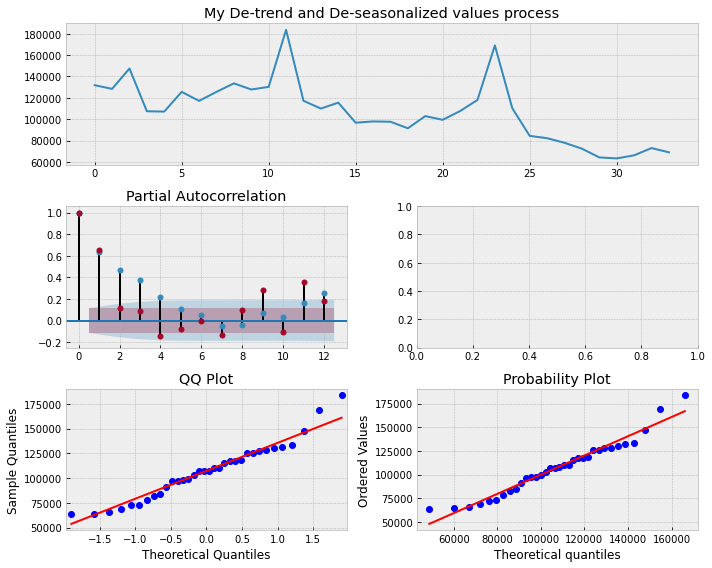

In [64]:
max_lag = 12
_ = tsplot(ts.values, lags=max_lag,title="My De-trend and De-seasonalized values process");

In [65]:
#ARMA, First create a multi-index dataframe with ("date_block_num", "shop_id", "item_id") as index in order to easily find the number of time an item_id was sold at month date_block_num.

sales_monthly = train.groupby(
    ["date_block_num", "shop_id", "item_id"])["date", "item_price",
                                              "item_cnt_day"].agg({
    "date": ["min", "max"],
    "item_price": "mean",
    "item_cnt_day": "sum"})

#Each "shop_id", "item_id" is a time series for which we will find and create a SARIMAX model.

<ipython-input-65-34601dbab577>:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  sales_monthly = train.groupby(


In [67]:
sales_monthly.head(50)

date             item_price item_cnt_day
                                       min         max       mean          sum
date_block_num shop_id item_id                                                
0              2       27       11.01.2013  11.01.2013     2499.0            1
                       33       05.01.2013  05.01.2013      499.0            1
                       317      04.01.2013  04.01.2013      299.0            1
                       438      19.01.2013  19.01.2013      299.0            1
                       471      09.01.2013  22.01.2013      399.0            2
                       481      07.01.2013  07.01.2013      330.0            1
                       482      16.01.2013  16.01.2013     3300.0            1
                       484      13.01.2013  15.01.2013      300.0            2
                       491      09.01.2013  09.01.2013      600.0            1
                       534      02.01.2013  06.01.2013      399.0            2
                       556      03.01.2013  03.01.2013      199.0            1
                       642      04.01.2013  18.01.2013      149.0            2
                       651      04.01.2013  04.01.2013      149.0            2
                       657      10.01.2013  25.01.2013      149.0            3
                       677      10.01.2013  24.01.2013      149.0            3
                       700      03.01.2013  25.01.2013      199.0            4
                       785      22.01.2013  22.01.2013      349.0            1
                       791      14.01.2013  19.01.2013      600.0            2
                       804      14.01.2013  14.01.2013      240.0            1
                       839      22.01.2013  22.01.2013     3300.0            1
                       963      12.01.2013  12.01.2013       99.0            1
                       991      01.01.2013  01.01.2013       99.0            1
                       995      11.01.2013  11.01.2013       99.0            1
                       998      06.01.2013  20.01.2013       99.0            2
                       999      20.01.2013  20.01.2013       99.0            1
                       1000     20.01.2013  20.01.2013       99.0            1
                       1001     20.01.2013  20.01.2013       99.0            1
                       1007     11.01.2013  25.01.2013      449.0            3
                       1010     21.01.2013  21.01.2013      449.0            1
                       1013     04.01.2013  20.01.2013      299.0            3
                       1021     06.01.2013  06.01.2013      399.0            2
                       1023     06.01.2013  13.01.2013      299.0            2
                       1026     13.01.2013  13.01.2013      299.0            1
                       1032     23.01.2013  23.01.2013      299.0            1
                       1067     06.01.2013  06.01.2013      449.0            1
                       1109     11.01.2013  11.01.2013      149.0            1
                       1112     19.01.2013  19.01.2013      499.0            1
                       1167     06.01.2013  06.01.2013     1100.0            1
                       1204     03.01.2013  03.01.2013      299.0            1
                       1224     05.01.2013  05.01.2013      399.0            1
                       1247     07.01.2013  07.01.2013      299.0            1
                       1362     10.01.2013  10.01.2013       49.0            1
                       1409     17.01.2013  17.01.2013     1398.5            1
                       1418     03.01.2013  19.01.2013      349.0            3
                       1420     04.01.2013  19.01.2013      349.0            3
                       1430     06.01.2013  06.01.2013      698.0            1
                       1467     03.01.2013  03.01.2013      899.0            1
                       1470     03.01.2013  19.01.2013      599.0            4
         

In [81]:
#fitting SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

array = []

for i, row in test.iterrows():
   
    try:
        # We get all the dates/indexes in order to fill the blanks of the time series with 0s later on 
        # We have a KeyError issue at row['shop_id']:  5  row['item_id']:  5003 which I don't have in my local notebook
        existing_indexes = [x[0] 
                            for x in sales_monthly.loc[pd.IndexSlice[:, 
                            [row['shop_id']], [row['item_id']]], :].index]
        # We multiply the price of the item by the number of this kind of item sold
        ts = pd.DataFrame(sales_monthly.loc[pd.IndexSlice[:, # We have a key error here
                      [row['shop_id']], [row['item_id']]], :]['item_price'].values *
                      sales_monthly.loc[pd.IndexSlice[:, 
                      [row['shop_id']], [row['item_id']]], :]['item_cnt_day'].values).T.iloc[0]
        ts_values = list(ts.values)
        if ts.values != [] and len(ts.values) > 4:
          # if this item isn't sold every month, we need to fill the gaps in the 
          # sellings list
            if len(ts.values<3):
                all_indexes = list(range(33))
                insert_at_indexes = set(all_indexes) - set(existing_indexes)
                insert_at_indexes = [list(group) 
                            for group in (insert_at_indexes)][1:]
                insert_at_indexes = [item for sublist in insert_at_indexes for item in sublist]
                # we only take the last one 
                for insert_at in insert_at_indexes:
                      ts_values[insert_at:insert_at] = [0.]
            best_aic = np.inf
            best_order = None
            best_model = None

          # we need to test different orders, but let's have a go with that ...
            ranges = range(1, 5)
            for difference in ranges:
                tmp_model = SARIMAX(ts_values, order=(0, 1, 0), trend='t').fit()
                tmp_aic = tmp_model.aic
                if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_difference = difference
                        best_model = tmp_model
            if best_model is not None:
                y_hat = best_model.forecast()[0]
                if y_hat < 0:
                    y_hat = 0.5
            else:
                y_hat = 0.5
        else:
            y_hat = 0.5
    except KeyError:
        y_hat = 0.5
    d = {'id': row['ID'], 'item_cnt_month': y_hat}
    array.append(d)

df = pd.DataFrame(array)
df.reset_index(drop=True, inplace=True)

<ipython-input-81-186cd0c953c7>:20: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  if ts.values != [] and len(ts.values) > 4:


TypeError: 'int' object is not iterable

In [ ]:
mit.

In [121]:
! pip install yfinance

import yfinance as yf

msft = yf.Ticker("MSFT")

# get historical market data
hist = msft.history(period="5y")

  Created wheel for yfinance: filename=yfinance-0.1.55-py2.py3-none-any.whl size=22618 sha256=4baa986e851159a28266df463c2111cc2588faa6ad837dea5fc83934696ca6a2
  Stored in directory: /Users/jiguzmans/Library/Caches/pip/wheels/b4/c3/39/9c01ae2b4726f37024bba5592bec868b47a2fab5a786e8979a
  Created wheel for multitasking: filename=multitasking-0.0.9-py3-none-any.whl size=8367 sha256=9bccd1a754182fef1476674829db390e19b8b395b2a443d917106287c7871de1
  Stored in directory: /Users/jiguzmans/Library/Caches/pip/wheels/57/6d/a3/a39b839cc75274d2acfb1c58bfead2f726c6577fe8c4723f13
Successfully built yfinance multitasking


In [122]:
df_settle = hist['Close'].resample('MS').ffill().dropna()
df_settle.tail()

Date
2020-10-01    211.418289
2020-11-01    201.477280
2020-12-01    215.713181
2021-01-01    221.908905
2021-02-01    239.099304
Freq: MS, Name: Close, dtype: float64

In [124]:
#Here, the p-value is larger than 0.05, meaning the we cannot reject the null hypothesis stating that the time series 
#is non-stationary. Therefore, we must apply some transformation and some differencing to remove the trend and remove 
#the change in variance.
#Finding model parameters by grid search
#We could try to find the model parameters by detrending with a log-difference np.log(df_settle) and differenciating 
#df_settle.diff(seasonality) and then run the Augmented Dickey-Fuller test again to see if we have a stationary time series.
#Although these plots can give us a rough idea of the processes in play, it is better to test multiple scenarios 
#and choose the model that yield the lowest AIC.
#Therefore grid searching (p, d, q, s), allows to feed the data as it is without any transformation 
#since SARIMAX will do the transformation for you under the hood.

'We just need to find the model minimizing the AIC'

from statsmodels.tsa.stattools import adfuller

result = adfuller(df_settle)
print('ADF result', result[0])
print('p-value = ', result[1])

critical_values = result[4]

for key, value, in critical_values.items():
    print("critical values (%s): %.3f" % (key, value))

ADF result 2.325921140144809
p-value =  0.9989710666347107
critical values (1%): -3.563
critical values (5%): -2.919
critical values (10%): -2.597


In [138]:
import warnings
from statsmodels.tsa.statespace.sarimax import SARIMAX
# from statsmodels.api.tsa.statespace import SARIMAX

warnings.filterwarnings("ignore")

def arima_grid_search(dataframe, s):
    p = d = q = range(2)
    param_combinations = list(itertools.product(p, d, q))

    lowest_aic, pdq, pdqs = None, None, None

    total_iterations = 0
    for order in param_combinations:
        for (p, d, q) in param_combinations:
            seasonal_order = (p, d, q, s)
            total_iterations +=1
            try:
                model = SARIMAX(df_settle, order=order,
                                seasonal_order = seasonal_order,
                                enforce_stationarity=False,
                                enforce_invertibility=False,
                                disp=False
                              )
                model_result = model.fit(maxiter=200, disp=False)

            if not lowest_aic or model_result.aic < lowest_aic:
            lowest_aic = model_result.aic
            pdq, pdqs = order, seasonal_order

    except Exception as ex:
            continue

    return lowest_aic, pdq, pdqs

IndentationError: unexpected unindent (<ipython-input-138-60421f11cb4e>, line 27)

In [ ]:
lowest_aic, order, seasonal_order = arima_grid_search(df_settle, 12)
print('ARIMA{}x{}'.format(order, seasonal_order))
print('Lowest AIC: %.3f' % (lowest_aic))

#Therefore, this suggests are ARIMA model with an AR(1) process and a MA(0).
#The order of differencing (d) process is 1. But it's not related to the AIC, it has been found by the grid search 
#model itself.

In [135]:
#fitting SARIMAX
model = SARIMAX(
    df_settle, 
    order=order,
    seasonal_order = seasonal_order,
    enforce_stationarity=False,
    enforce_invertibility=False,
    disp=False
)

model_results = model.fit(maxiter=200, disp=False)

print(model_results.summary())

model_results.plot_diagnostics(figsize=(12,8));

model_results.resid.describe()

NameError: name 'SARIMAX' is not defined

From the normal Q-Q plot, we can see that we almost have a straight line, which suggest no systematic departure from normality. Also, the correlogram on the bottom right suggests that there is no autocorrelation in the residuals, and so they are effectively white noise.

Predicting the model - We are ready to plot the predictions of our model and forecast into the future:

In [ ]:
n = len(df_settle.index)
prediction = model_results.get_prediction(
    start=n-14*5, #changed from 12
    end=n+5
)

prediction_ci = prediction.conf_int()

In [ ]:
prediction_ci.head(3)

In [ ]:
plt.figure(figsize=(12,8))
ax = df_settle['2008':].plot(label='actual')
prediction_ci.plot(
    ax=ax, style=['--', '--'],
    label='predicted/forecasted')

ci_index = prediction_ci.index
lower_ci = prediction_ci.iloc[:, 0]
upper_ci = prediction_ci.iloc[:, 1]

ax.fill_between(ci_index, lower_ci, upper_ci,
                color='r', alpha= .1)

ax.set_xlabel('Time (years)')
ax.set_ylabel('Prices')

plt.legend()
plt.show()

In [133]:
#formating dates as a date object
sales.date = sales.date.apply(lambda x: datetime.datetime.strptime(x, "%d.%m.%Y"))
# check
print(sales.info())

NameError: name 'sales' is not defined

In [ ]:
# So we have ~2M sales of items in the period we were given.
# How do they look like?
sales_monthly = sales.groupby(
    ["date_block_num", "shop_id", "item_id"])["date","item_price",
                                              "item_cnt_day"].agg({
        "date":["min","max"],
        "item_price":"mean",
        "item_cnt_day":"sum"})

sales_monthly.head(20)

In [ ]:
# number of items per cat 
items.head()
x = items.groupby(['item_category_id']).count() # but count is in column item_id ?
x = x.sort_values(by='item_id',ascending=False)
x=x.iloc[0:10].reset_index()
x
# plot
plt.figure(figsize=(8,4))
ax=sns.barplot(x.item_category_id, x.item_id, alpha=0.8)
plt.title("Items per Category")
plt.ylabel("# of items", fontsize=12)
plt.xlabel("Category", fontsize=12)
plt.show()

In [132]:
The sales by category seem to be unbalanced.

First let's compute the total sales per month and plot that data.

ts = sales.groupby(['date_block_num'])['item_cnt_day'].sum()
# ts = sales.groupby(['date_block_num','shop_id'])['item_cnt_day'].sum()


out = sales.pivot_table(index='shop_id', 
                        columns='date_block_num',
                        values='item_cnt_day',
                        aggfunc='sum')
out = out.fillna(out.mean())
out.head()

SyntaxError: invalid syntax (<ipython-input-132-d653374fa793>, line 1)

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(ts)
plt.title("Total sales of the company")
plt.xlabel("Time")
plt.ylabel("# sales")
plt.show()

In [ ]:
plt.figure(figsize=(16,8))
for i,row in out.iterrows():
    plt.scatter(out.columns, row)
plt.title("Total sales of the company")
plt.xlabel("Time")
plt.ylabel("# sales")
plt.show()

In [ ]:
plt.figure(figsize=(16,6))
plt.plot(ts.rolling(window=12,center=False).mean(), label = "rolling mean")
plt.plot(ts.rolling(window=12, center=False).std(), label = "rolling std")
plt.legend()
plt.show()

In [131]:
import statsmodels.api as sm
res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="multiplicative")
fig=res.plot()

res = sm.tsa.seasonal_decompose(ts.values, freq=12, model="addidtive")
fig=res.plot()

AttributeError: 'float' object has no attribute 'values'

In [130]:
#Now I need to predict at the (shop,item_level)

import statsmodels.api as smt
import statsmodels
import scipy.stats as scs
from pandas import Series

ts = sales.groupby(["date_block_num"])["item_cnt_day"].sum()

def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

new_ts = difference(ts, 12)


def tsplot(y, lags=None, figsize=(10, 8), style='bmh',title=''):
    if not isinstance(y, pd.Series):
        y = pd.Series(y)
    with plt.style.context(style):    
        fig = plt.figure(figsize=figsize)
        #mpl.rcParams['font.family'] = 'Ubuntu Mono'
        layout = (3, 2)
        ts_ax = plt.subplot2grid(layout, (0, 0), colspan=2)
        acf_ax = plt.subplot2grid(layout, (1, 0))
        pacf_ax = plt.subplot2grid(layout, (1, 1))
        qq_ax = plt.subplot2grid(layout, (2, 0))
        pp_ax = plt.subplot2grid(layout, (2, 1))
        
        y.plot(ax=ts_ax)
        ts_ax.set_title(title)
        statsmodels.graphics.tsaplots.plot_acf(y, lags=lags, ax=acf_ax, alpha=0.5)
        statsmodels.graphics.tsaplots.plot_pacf(y, lags=lags, ax=pacf_ax, alpha=0.5)
        smt.qqplot(y, line='s', ax=qq_ax)
        qq_ax.set_title('QQ Plot')        
        scs.probplot(y, sparams=(y.mean(), y.std()), plot=pp_ax)

        plt.tight_layout()
    return 

max_lag = 12
_ = tsplot(ts.values, lags=max_lag,title="My De-trend and De-seasonalized values process");

NameError: name 'sales' is not defined

ARMA: We are now going to buil our model to predict the future sales for the company.

We first need to create a multi-index dataframe with ("date_block_num", "shop_id", "item_id") as index in order to easily find the number of time an item_id was sold at month date_block_num.

In [ ]:
sales_monthly = sales.groupby(
    ["date_block_num", "shop_id", "item_id"])["date", "item_price",
                                              "item_cnt_day"].agg({
    "date": ["min", "max"],
    "item_price": "mean",
    "item_cnt_day": "sum"})

sales_monthly.head()

Each "shop_id", "item_id" is a time series for which we will find and create a SARIMAX model.

We now find these couples iterating through test and creating the related SARIMAX model if we have enough data (at least 33 month of sales)

In [ ]:
#fitting SARIMAX
from statsmodels.tsa.statespace.sarimax import SARIMAX

array = []

for i, row in test.iterrows():
   
    try:
        # We get all the dates/indexes in order to fill the blanks of the time series with 0s later on 
        # We have a KeyError issue at row['shop_id']:  5  row['item_id']:  5003 which I don't have in my local notebook
        existing_indexes = [x[0] 
                            for x in sales_monthly.loc[pd.IndexSlice[:, 
                            [row['shop_id']], [row['item_id']]], :].index]
        # We multiply the price of the item by the number of this kind of item sold
        ts = pd.DataFrame(sales_monthly.loc[pd.IndexSlice[:, # We have a key error here
                      [row['shop_id']], [row['item_id']]], :]['item_price'].values *
                      sales_monthly.loc[pd.IndexSlice[:, 
                      [row['shop_id']], [row['item_id']]], :]['item_cnt_day'].values).T.iloc[0]
        ts_values = list(ts.values)
        if ts.values != [] and len(ts.values) > 4:
          # if this item isn't sold every month, we need to fill the gaps in the 
          # sellings list
            if len(ts.values<3):
                all_indexes = list(range(33))
                insert_at_indexes = set(all_indexes) - set(existing_indexes)
                insert_at_indexes = [list(group) 
                            for group in mit.consecutive_groups(insert_at_indexes)][1:]
                insert_at_indexes = [item for sublist in insert_at_indexes for item in sublist]
                # we only take the last one 
                for insert_at in insert_at_indexes:
                      ts_values[insert_at:insert_at] = [0.]
            best_aic = np.inf
            best_order = None
            best_model = None

          # we need to test different orders, but let's have a go with that ...
          ranges = range(1, 5)
            for difference in ranges:
                tmp_model = SARIMAX(ts_values, order=(0, 1, 0), trend='t').fit()
                tmp_aic = tmp_model.aic
                if tmp_aic < best_aic:
                        best_aic = tmp_aic
                        best_difference = difference
                        best_model = tmp_model
            if best_model is not None:
                y_hat = best_model.forecast()[0]
                if y_hat < 0:
                    y_hat = 0.5
            else:
                y_hat = 0.5
        else:
            y_hat = 0.5
    except KeyError:
        y_hat = 0.5
    d = {'id': row['ID'], 'item_cnt_month': y_hat}
    array.append(d)

df = pd.DataFrame(array)
df.reset_index(drop=True, inplace=True)

In [ ]:
#Try LSTM RNNs too.